# **PART 4:** TCRex results & statistics

In [1]:
import os
# Set the working directory to the repository directory
os.chdir("/home/sebastiaan/PhD/Repositories/book_chapter/")

Once again, we will need the `pandas` library for handling the data. In addition, this part of the tutorial requires the `scipy`  and `statsmodels` libraries.

In [2]:
import pandas as pd
import numpy as np

from scipy.stats import binom_test
from statsmodels.stats.multitest import multipletests
from matplotlib.cm import ScalarMappable

In [3]:
def read_tcrex_results(folder, file):
    
    """
    Read in a TCRex results file as a pandas dataframe. 
    Ignores meta data information preceded with a '#' sign.
    
    Args:
    - folder: The folder where the TCRex results file is located
    - file: The name of the TCRex results file
    """
    return pd.read_csv(os.path.join(folder, file), sep = "\t", comment = "#")

We will perform a simple quantitative evaluation of the TCRex prediction results by calculating the identification rate and an enrichment score for a certain epitope. The identification rate describes the percentage of epitope-specific TCRs TCRex found in a repertoire (i.e. the number of TCRs for which a hit was found). To calculate the enrichment score, we perform a one-sided binomial test to assess significant overrepresentation (enrichment) of a particular epitope in a sample.

In [4]:
def identification_rate(nr_identified, repertoire_size):
    
    """
    Calculate the percentage of epitope-specific TCRs in a repertoire.
    
    Args:
    - nr_identified: The number of identified epitope-specific TCRs 
    - repertoire_size: The number of TCRs in the original repertoire, reported on the TCRex results page
    
    """
    return (nr_identified / repertoire_size) * 100

def enrichment_analysis(
    nr_identified: int, 
    repertoire_size: int, 
    threshold: float = 0.001
    ):
    """
    Calculate the p value of a one sided binomial test.

    Args:
    - nr_identified:  The number of identified epitope-specific TCRs 
    - repertoire_size: The number of TCRs in the original repertoire, reported on the TCRex results page
    - enrichment_threshold: Probability of success as defined in a binomial test.

    """
    return binom_test(
         x = nr_identified, 
         n = repertoire_size,
         p = threshold,
         alternative = 'greater'
         )

Using the following sequence of commands, we can calculate the quantitative metrics that we defined previously. That is, for a single epitope. Here, we will illustrate this using the epitope 'FLKEKGGL'.

In [5]:
# Read the resuls
tcrex_results = read_tcrex_results('./results/tcrex','P1_0_tcrex.tsv')
tcrex_results_epitope = tcrex_results[tcrex_results.epitope == "FLKEKGGL"]

# Calculate the number of identified epitope-specific TCRs 
nr_identified = tcrex_results_epitope.shape[0]  

# Define the repertoire size
repertoire = pd.read_csv('./data/examples/P1_0.tsv', sep = '\t')
repertoire_size = repertoire.shape[0]

p = enrichment_analysis(nr_identified, repertoire_size) # p-value
ir = identification_rate(nr_identified, repertoire_size) # identification rate

# Calculate the identification metrics
print(f"p value: {p}")
print(f"Identification rate: {ir}")

p value: 1.0
Identification rate: 0.01628621865993503


Most of the time, however, we use multiple TCRex epitope models. Therefore, we should calculate the enrichment score for each epitope individually. The following function does this by looping through every epitope in the results file.

In [6]:
def calculate_metrics(
    results: pd.DataFrame, 
    repertoire_size: int, 
    threshold: float,
    mtc: bool = True
    ):
    """
    Calculate the identification rate and enrichment analysis p value for every epitope in a TCRex results file.
    
    Args:
    - results: Pandas DataFrame containing the TCRex results
    - repertoire_size: The number of TCRs in the original repertoire, reported on the TCRex results page
    - enrichment_threshold: Probability of success as defined in a binomial test.
    - mtc: p-value correction for multiple tests using Benjamini-Hochberg method for controlling FDR.
    """
    # For every epitope, store the calculated metrics in a dictionary
    cols = ["epitope", "pathology", "identification_rate", "p_value"]
    metrics = pd.DataFrame(columns = cols)
    
    # Loop through epitopes
    for epitope in results.epitope.unique():
        # Retrieve all TCRs specific for the epitope
        epitope_data = results[results['epitope'] == epitope]
        pathology = epitope_data.pathology.iloc[0]
        # Calculate the number of epitope-specific TCRs
        nr_identified = epitope_data.shape[0]
        # Calculate metrics
        ir = identification_rate(nr_identified, repertoire_size)
        p = enrichment_analysis(nr_identified, repertoire_size, threshold)
        # Add to dataframe
        metrics = pd.concat([metrics, pd.DataFrame([[epitope, pathology, ir, p]], columns = cols)])
        
    if mtc:
        # Calculate corrected p-values
        p_adj = multipletests(
            pvals = metrics.p_value, 
            method = 'fdr_bh', 
            is_sorted = False
            )[1]
        # Add to dataframe
        metrics['adjusted_p_value'] = p_adj
        
    return metrics 

Next, we define a function for plotting the epitope distribution of each repertoire as a bar chart with annotated labels.

In [7]:
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches

def plot_epitope_distribution(
    metrics_df: pd.DataFrame,
    name: str,
    colordict: dict,
    y_value: str = "identification_rate",
    y_axis: str = "Identification rate (%)",
    title: str = None,
    plot_legend = True
    ):
    
    # Sort data with respect to target attribute
    metrics_df = metrics_df.sort_values(by = y_value, ascending = False)

    # Map colors to labels
    metrics_df["colors"] = metrics_df.pathology.map(colordict)
    
    # Plotting
    fig, ax = plt.subplots(dpi = 100)
    
    # Bar plot
    ax.bar(
        x = metrics_df.epitope, # x values
        height = metrics_df[y_value], # y values
        color = metrics_df.colors # color labels
        )
    
    # Plot the names of the epitopes
    _ = ax.set_xticklabels(
        metrics_df.epitope, 
        rotation = 90, 
        fontsize = 8
        )

    # Axis labels
    ax.set_xlabel("epitopes")
    ax.set_ylabel(y_axis)
    ax.set_title(title)
    
    if plot_legend:
        # Set up figure legend
        handles = [mpatches.Patch(color=colordict[i]) for i in colordict]
        labels = [i for i in colordict]
        ax.legend(handles, labels, fontsize=6)

    fig.tight_layout()
    fig.savefig(f"./results/figures/{'.'.join([name,'png'])}", format = "png")

Finally, we can put all this together and calculate some the statistics we just defined for every individual epitope for which we screened.

### **Calculate statistics for P1 at day 0**

In [53]:
# Read the resuls
results_day_0 = read_tcrex_results('./results/tcrex','P1_0_tcrex.tsv')

# Define the repertoire size
repertoire_day_0 = pd.read_csv('./data/examples/P1_0.tsv', sep = '\t')
repertoire_size_day_0 = repertoire_day_0.shape[0]

# Calculate metrics for epitopes
metrics_day_0 = calculate_metrics(
    results = results_day_0,
    repertoire_size = repertoire_size_day_0,
    threshold = 0.0001
    )

# Show results
metrics_day_0.sort_values(by = 'adjusted_p_value').head(10)

,epitope,pathology,identification_rate,p_value,adjusted_p_value
0,TPQDLNTML,HIV,0.713104,0.0,0.0
0,NLVPMVATV,CMV,1.112989,0.0,0.0
0,ELAGIGILTV,Melanoma,0.982117,0.0,0.0
0,GTSGSPIVNR,DENV1,0.084049,0.0,0.0
0,LPRRSGAAGA,Influenza,0.047695,0.0,0.0
0,HPVGEADYFEY,EBV,0.039843,0.0,0.0
0,VTEHDTLLY,CMV,0.037226,0.0,0.0
0,GLCTLVAML,EBV,0.036062,0.0,0.0
0,TPRVTGGGAM,CMV,0.033736,0.0,0.0
0,AMFWSVPTV,Melanoma,0.031118,0.0,0.0


### **Calculate statistics for P1 at day 15**

In [11]:
# Read the resuls
results_day_15 = read_tcrex_results('./results/tcrex','P1_15_tcrex.tsv')

# Define the repertoire size
repertoire_day_15 = pd.read_csv('./data/examples/P1_15.tsv', sep = '\t')
repertoire_size_day_15 = repertoire_day_15.shape[0]

# Calculate metrics for epitopes
metrics_day_15 = calculate_metrics(
    results = results_day_15,
    repertoire_size = repertoire_size_day_15,
    threshold = 0.0001
    )

# Show results
metrics_day_15.head()

,epitope,pathology,identification_rate,p_value,adjusted_p_value
0,LLWNGPMAV,YellowFeverVirus,0.019477,0.000004,0.00001
0,GTSGSPIINR,DENV3/4,0.028019,0.0,0.0
0,NLVPMVATV,CMV,0.97316,0.0,0.0
0,FLYNLLTRV,Melanoma,0.01401,0.023254,0.037982
0,ATDALMTGY,HCV,0.011618,0.213255,0.267935


Next, we will prepare the color labels to annotate the epitope distribution bar charts (function defined previously).

In [12]:
from matplotlib import cm

# Get colors
cmap = cm.get_cmap('tab20') # choose colormap
colors = cmap.colors # extract colors

pathologies = set(metrics_day_0.pathology).union(set(metrics_day_15.pathology))
colorlabels = dict(zip(pathologies, colors[:len(pathologies)]))

### **Plot epitope distribution for P1 at day 0**

/tmp/ipykernel_73447/236584529.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(


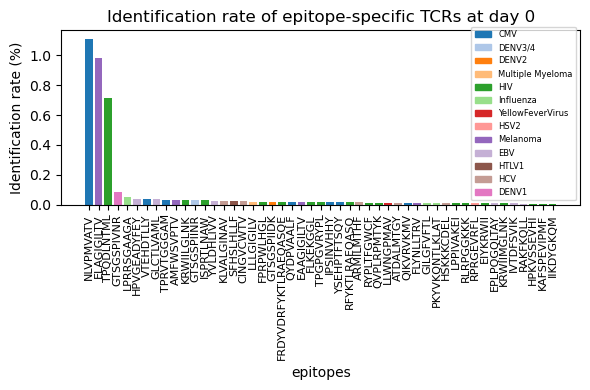

In [25]:
plot_epitope_distribution(
    metrics_df = metrics_day_0, 
    colordict = colorlabels, 
    name = 'P1_0_epitope_distribution',
    title = "Identification rate of epitope-specific TCRs at day 0"
    )

### **Plot epitope distribution for P1 at day 15**

/tmp/ipykernel_73447/236584529.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(


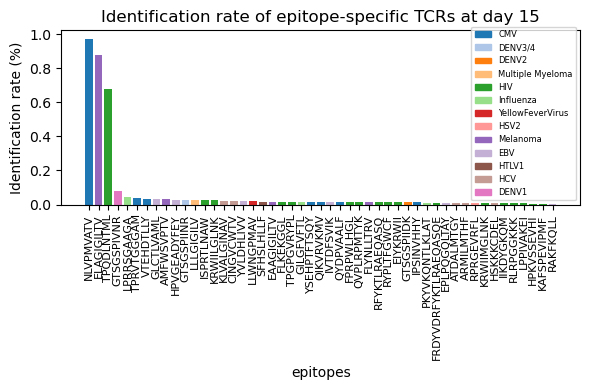

In [26]:
plot_epitope_distribution(
    metrics_df = metrics_day_15, 
    colordict = colorlabels, 
    name = 'P1_15_epitope_distribution',
    title = "Identification rate of epitope-specific TCRs at day 15"
    )

Next, we will calculate the fold change in epitope-specific TCR expression between day 0 and day 15. This will give an indication of which TCRs have expanded (or contracted) between two matched repertoires.

In [15]:
metrics = metrics_day_0.merge(right = metrics_day_15, on = ["epitope", "pathology"], how = "outer")

# We need to make some adjustments to these columns
ir_cols = ["identification_rate_x", "identification_rate_y"]
p_cols = ["p_value_x", "p_value_y", "adjusted_p_value_x", "adjusted_p_value_y"]

# Fill NAs identification rate with 0
# Normalize with minimum identification rate to prevent division by zero
metrics[ir_cols] = metrics[ir_cols].fillna(0) + metrics[ir_cols].min()
# Fill NAs p values rate with 0
metrics[p_cols] = metrics[p_cols].fillna(1)

# # Calculate fold change (B/A)
metrics["ir_fold_change"] = metrics["identification_rate_y"] / metrics["identification_rate_x"]
metrics["ir_fold_change"] = np.log2(metrics["ir_fold_change"].astype(float))

metrics.head()

,epitope,pathology,identification_rate_x,p_value_x,adjusted_p_value_x,identification_rate_y,p_value_y,adjusted_p_value_y,ir_fold_change
0,SFHSLHLLF,HTLV1,0.028792,5.346627e-11,1.541087e-10,0.02221,5.070172e-05,1.307571e-04,-0.374415
1,LLWNGPMAV,YellowFeverVirus,0.019485,2.346990e-02,3.593829e-02,0.023577,3.649524e-06,9.934815e-06,0.275009
2,EIYKRWII,HIV,0.014541,7.952659e-01,9.278103e-01,0.017427,4.877294e-02,7.242043e-02,0.261143
3,TPQDLNTML,HIV,0.71892,0.000000e+00,0.000000e+00,0.679298,0.000000e+00,0.000000e+00,-0.081787
4,KRWIILGLNK,HIV,0.036062,1.010611e-21,4.501813e-21,0.028361,4.947448e-11,1.731607e-10,-0.346583


Finally, we can plot the results.

/tmp/ipykernel_73447/236584529.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(


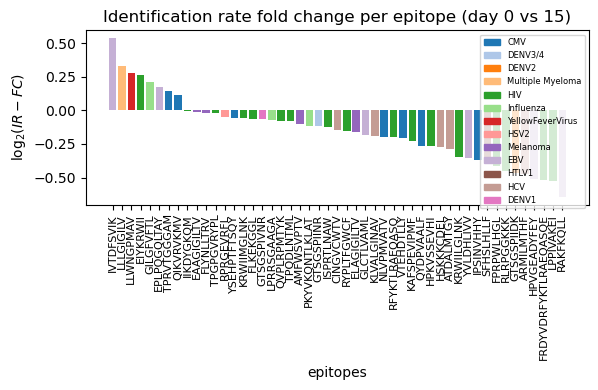

In [49]:
plot_epitope_distribution(
    metrics_df = metrics, 
    name = "epitope_fold_change_epitopes",
    colordict = colorlabels,
    y_value = "ir_fold_change",
    y_axis = r"$\log_{2}(IR-FC)$", # IR-FC = identification rate fold change
    title = 'Identification rate fold change per epitope (day 0 vs 15)'
    )

/tmp/ipykernel_73447/3853833814.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation = 90)


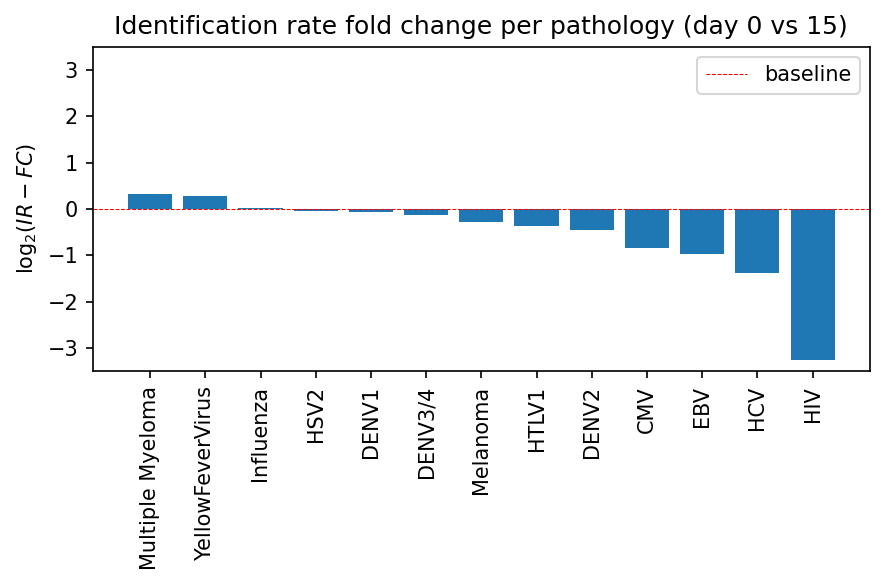

In [47]:
pathology_grouped = metrics.groupby('pathology').ir_fold_change.sum()
pathology_grouped = pathology_grouped.sort_values(ascending = False)

fig, ax = plt.subplots(dpi = 150)

x = pathology_grouped.index
y = pathology_grouped

ax.bar(x = x, height = y)
ax.axhline(y = 0, c = 'r', ls = '--', lw = .5, label = 'baseline')
ax.set_ylabel(r'$\log_{2}(IR-FC)$')
ax.set_xticklabels(x, rotation = 90)
ax.set_title('Identification rate fold change per pathology (day 0 vs 15)')
ax.set_ylim(-3.5, 3.5)
ax.legend()

fig.tight_layout()

fig.savefig('./results/figures/ir_fold_change_pathologies.png', format = 'png', bbox_inches = 'tight')